### 1. Importando dependências e funções de utilidade

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import math
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score, silhouette_samples, accuracy_score

In [74]:
def find_best_k(X_):
    
    X_ = pd.DataFrame(MinMaxScaler().fit_transform(X_))
    ans = {'inertias': [], 'calinski_scores': [], 'davies_scores': [], 'silhouette_scores': [], 'BIC': []}
    
    for k in range(2, 10):
        model = KMeans(n_clusters=k, n_init='auto', random_state=19)
        labels = model.fit_predict(X_)
    
        inertia = model.inertia_
        calinski = calinski_harabasz_score(X_, labels)
        davies = davies_bouldin_score(X_, labels)
        silhouette = silhouette_score(X_, labels)
        bic = bic_score(k, X_)
    
        # Append the inertia to the list of inertias
        ans['inertias'].append(inertia)
        ans['calinski_scores'].append(calinski)
        ans['davies_scores'].append(davies)
        ans['silhouette_scores'].append(silhouette)
        ans['BIC'].append(bic)
    
    return ans

In [77]:
def plot_best_k_scores(best_k_scores):
    fig, ax = plt.subplots(ncols=5, figsize=(20,4))

    ks = range(2, 10)
    i=0
    for key in best_k_scores:
        ax[i].plot(ks, best_k_scores[key], '-o', color='black', alpha=0.7)
        ax[i].set_xlabel("number os clusters")
        ax[i].set_title(key)
        ax[i].set_xticks(range(1,10))
    
        if key != 'inertias':
            if key != 'davies_scores' and key != 'BIC':
                best_score = max(best_k_scores[key])
            else:
                best_score = min(best_k_scores[key])
    
            ax[i].axvline(x = best_k_scores[key].index(best_score) + 2, color = 'r', linestyle = '--')
    
        i += 1

In [44]:
def scatter_clusters(k_clusters, PCA_components):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
    
    labels = k_clusters.fit_predict(PCA_components)
    sample_distances = k_clusters.fit_transform(PCA_components)
    sample_silhouette_values = silhouette_samples(PCA_components, labels)
    silhouette_avg = silhouette_score(PCA_comp, labels)
    k = sample_distances.shape[1]
    
    y_lower = 10
    colors = {0: 'red', 1: 'black', 2: 'yellow'}
    for i in range(k):
        scatter = PCA_components[labels == i]
        
        ax1.scatter(scatter.loc[:,0], scatter.loc[:,1], color=cm.nipy_spectral(float(i) / 2), alpha=0.6, edgecolor='black')
        ax1.plot(k_clusters.cluster_centers_[i][0], k_clusters.cluster_centers_[i][1], 'rs')
        
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / 2)
        ax2.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10
        
    ax1.set_title("Cluster visualization for k = {k}".format(k=k))
    ax1.set_xlabel("PCA 1")
    ax1.set_ylabel("PCA 2")
    
    ax2.set_title("The silhouette plot for all samples")
    ax2.set_xlabel("The sample silhouette coefficient values")
    ax2.set_ylabel("Cluster label")

    ax2.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax2.text(silhouette_avg + .01, .5, round(silhouette_avg, 4), color='red')

    ax2.set_yticks([])
    ax2.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()


In [96]:
def bic_score(k, X_):
    gmm = GaussianMixture(n_components=k, init_params='kmeans', random_state=42)
    gmm.fit(X_)
    return gmm.bic(X_)

### 2. Lendo a base de dados e removendo colunas

In [6]:
base = pd.read_csv("../dataset/College.csv")

In [7]:
base.sample(5)

Unnamed: 0 Private  Apps  Accept  Enroll  Top10perc  \
121               Coker College     Yes   604     452     295         15   
132  College of Saint Elizabeth     Yes   444     359     122         34   
385   Moorhead State University      No  2442    2164    1189         12   
567    SUNY College at Cortland      No  7888    3519    1036          6   
226       Goldey Beacom College     Yes   633     468     284         10   

     Top25perc  F.Undergrad  P.Undergrad  Outstate  Room.Board  Books  \
121         47          690          222      9888        4502    400   
132         53          493          968     10900        5250    380   
385         37         5983         1075      4426        2664    600   
567         40         5011          346      6550        4680    630   
226         27          823          963      6120        2985    531   

     Personal  PhD  Terminal  S.F.Ratio  perc.alumni  Expend  Grad.Rate  
121      1000   64        77       12.1           39    8741         75  
132      1000   68        70       11.4           23    9447         78  
385      1000   76        81       18.1           19    4795         60  
567      1274   82        85       17.8           17    5563         53  
226      1830   25        25       27.6            4    6081         36

In [8]:
base.describe()

Apps        Accept       Enroll   Top10perc   Top25perc  \
count    777.000000    777.000000   777.000000  777.000000  777.000000   
mean    3001.638353   2018.804376   779.972973   27.558559   55.796654   
std     3870.201484   2451.113971   929.176190   17.640364   19.804778   
min       81.000000     72.000000    35.000000    1.000000    9.000000   
25%      776.000000    604.000000   242.000000   15.000000   41.000000   
50%     1558.000000   1110.000000   434.000000   23.000000   54.000000   
75%     3624.000000   2424.000000   902.000000   35.000000   69.000000   
max    48094.000000  26330.000000  6392.000000   96.000000  100.000000   

        F.Undergrad   P.Undergrad      Outstate   Room.Board        Books  \
count    777.000000    777.000000    777.000000   777.000000   777.000000   
mean    3699.907336    855.298584  10440.669241  4357.526384   549.380952   
std     4850.420531   1522.431887   4023.016484  1096.696416   165.105360   
min      139.000000      1.000000   2340.000000  1780.000000    96.000000   
25%      992.000000     95.000000   7320.000000  3597.000000   470.000000   
50%     1707.000000    353.000000   9990.000000  4200.000000   500.000000   
75%     4005.000000    967.000000  12925.000000  5050.000000   600.000000   
max    31643.000000  21836.000000  21700.000000  8124.000000  2340.000000   

          Personal         PhD    Terminal   S.F.Ratio  perc.alumni  \
count   777.000000  777.000000  777.000000  777.000000   777.000000   
mean   1340.642214   72.660232   79.702703   14.089704    22.743887   
std     677.071454   16.328155   14.722359    3.958349    12.391801   
min     250.000000    8.000000   24.000000    2.500000     0.000000   
25%     850.000000   62.000000   71.000000   11.500000    13.000000   
50%    1200.000000   75.000000   82.000000   13.600000    21.000000   
75%    1700.000000   85.000000   92.000000   16.500000    31.000000   
max    6800.000000  103.000000  100.000000   39.800000    64.000000   

             Expend  Grad.Rate  
count    777.000000  777.00000  
mean    9660.171171   65.46332  
std     5221.768440   17.17771  
min     3186.000000   10.00000  
25%     6751.000000   53.00000  
50%     8377.000000   65.00000  
75%    10830.000000   78.00000  
max    56233.000000  118.00000

In [9]:
base.Private.value_counts()

Yes    565
No     212
Name: Private, dtype: int64

In [10]:
labels = base.Private.apply(lambda x: {'No': 0, 'Yes': 1}[x])
names = base['Unnamed: 0']
X_ = base.drop(columns=['Unnamed: 0', 'Private'])

In [11]:
X_.sample(5)

Apps  Accept  Enroll  Top10perc  Top25perc  F.Undergrad  P.Undergrad  \
560  13528    9198    1843         16         61        10168         1231   
730   1190     978     324         12         30         1280           61   
731    280     143      79          5         27          327          110   
104   2785    2011    1007          8         65         6507          898   
177   3330    2730    1303         15         36         6706         2640   

     Outstate  Room.Board  Books  Personal  PhD  Terminal  S.F.Ratio  \
560      6550        4355    700      1560   93        96       17.4   
730      8840        3620    500      1200   57        58       16.2   
731      5590        2900    650      1952   53        63       15.1   
104      7242        3603    654      1416   67        89       18.1   
177      5800        3000    600      2200   73        75       14.0   

     perc.alumni  Expend  Grad.Rate  
560           16    9075         74  
730           26    6563         63  
731            4    4839         90  
104            0    6413         51  
177            9    9825         42

In [12]:
X_.isnull().sum()

Apps           0
Accept         0
Enroll         0
Top10perc      0
Top25perc      0
F.Undergrad    0
P.Undergrad    0
Outstate       0
Room.Board     0
Books          0
Personal       0
PhD            0
Terminal       0
S.F.Ratio      0
perc.alumni    0
Expend         0
Grad.Rate      0
dtype: int64

### 3. Definindo o melhor número K de clusters para a base

A maioria dos métodos nos sugerem k = 2.

In [97]:
best_k_scores = find_best_k(X_)

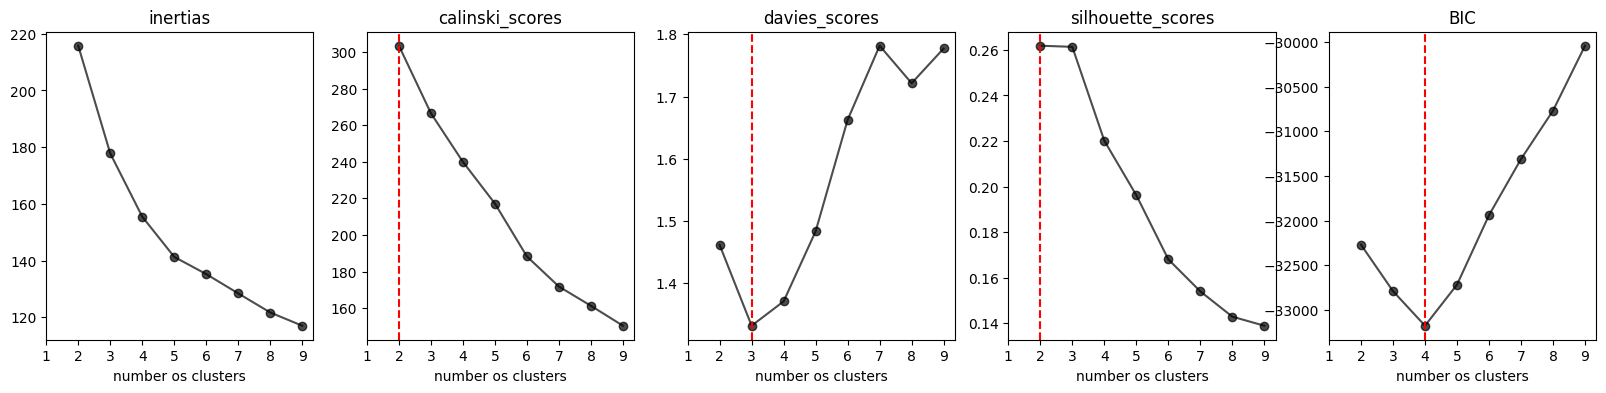

In [98]:
plot_best_k_scores(best_k_scores)

### 4. Utilizando Principal Components Analysis para visualizar os clusters

Os componentes resultantes da aplicação do PCA representam as direções de máxima variância nos dados.

In [15]:
pca = PCA(n_components=17)

pipe = Pipeline(steps=[("scaler", MinMaxScaler()),
                       ("pca", pca)])

In [16]:
PCA_comp = pd.DataFrame(pipe.fit_transform(X_))

Aqui têm-se as PCA features ordenadas de acordo com a porcentagem de variância expressa em relação ao todo.

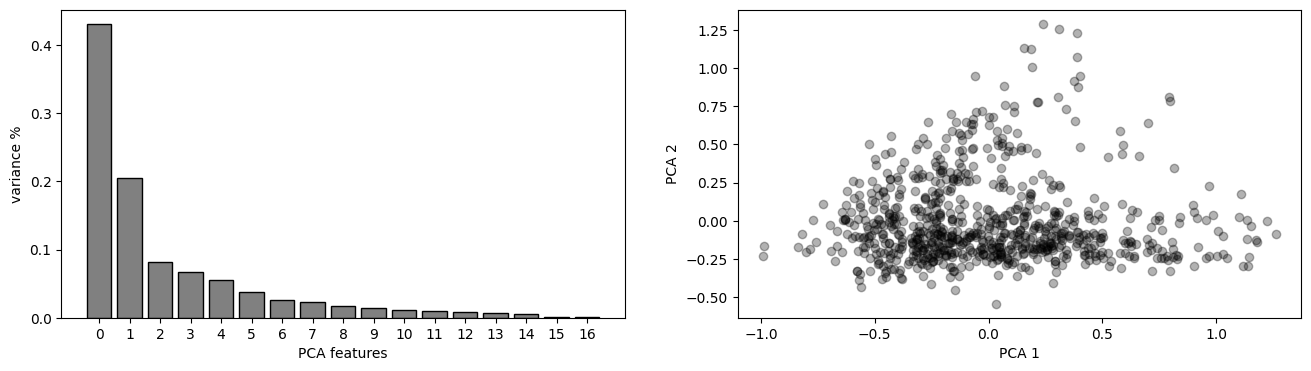

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

features = range(pca.n_components_)
ax1.bar(features, pca.explained_variance_ratio_, color='gray', edgecolor='black')
ax1.set_xlabel('PCA features')
ax1.set_ylabel('variance %')
ax1.set_xticks(features)

ax2.scatter(PCA_comp[0], PCA_comp[1], alpha=.3, color='black')
ax2.set_xlabel('PCA 1')
ax2.set_ylabel('PCA 2')

plt.show()

#### Clusterizando com K-means e visualizando os coeficientes de silhouette para cada amostra

A <a href='https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html'>documentação do sklearn</a> calcula o <strong>silhouette_score</strong> como segue: "The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b).". Assim, quando o silhouette_score médio para um conjunto de amostras se aproxima de 1, os clusters estão bem densos e distantes uns dos outros. Quando esse score é muito próximo de -1, não há quase nenhuma formação de clusters. No entanto, quando esse índice beira o 0, os clusters estão de certa forma definidos, mas há sobreposição entre as amostras de cada grupo: não é tão evidente a formação dos grupos.

In [19]:
two = KMeans(n_clusters=2, n_init='auto', random_state=42)
three = KMeans(n_clusters=3, n_init='auto', random_state=42)

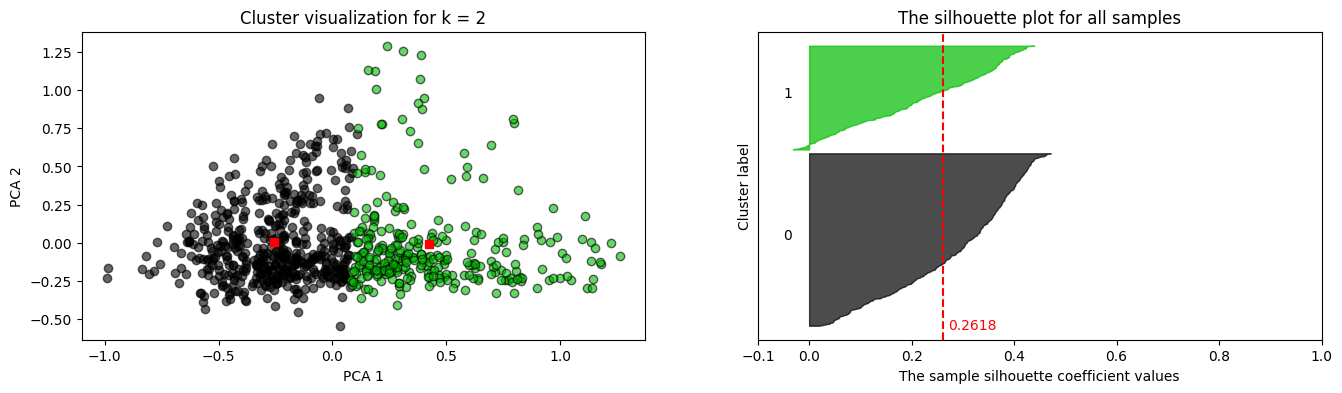

In [45]:
scatter_clusters(two, PCA_comp)

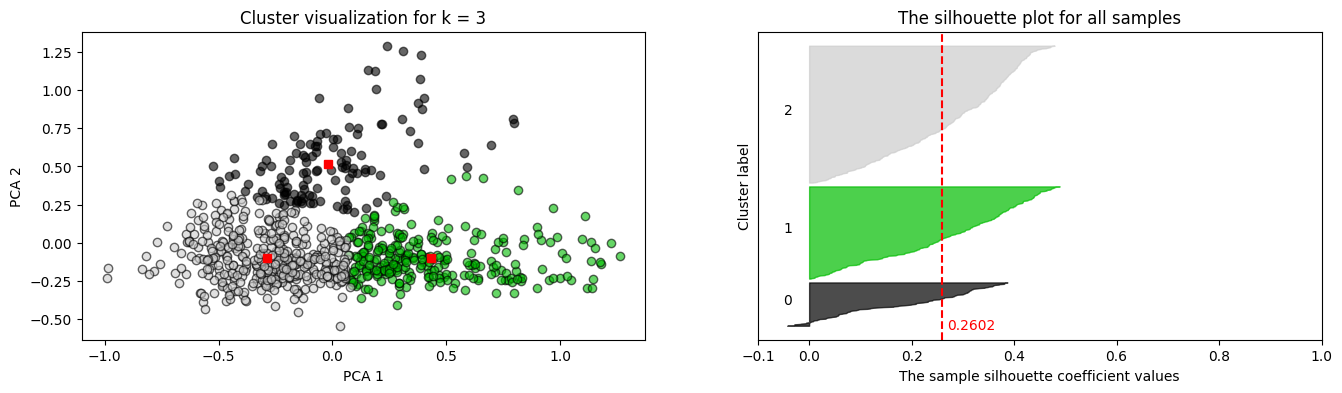

In [46]:
scatter_clusters(three, PCA_comp)

#### Clusterizando com K-medoids e visualizando os coeficientes de silhouette para cada amostra

Percebe-se uma mudança nas posições finais dos centros dos clusters, aproximando-os. Assim, os clusters acabam se sobrepondo mais, o que reflete na diminuição do silhouette_score médio. Para k = 2, essa sobreposição é mais notória mas não tão expressiva. Já para k = 3, é bem visual a sobreposição.

In [22]:
two_medoids = KMedoids(n_clusters=2, random_state=42)
three_medoids = KMedoids(n_clusters=3, random_state=42)

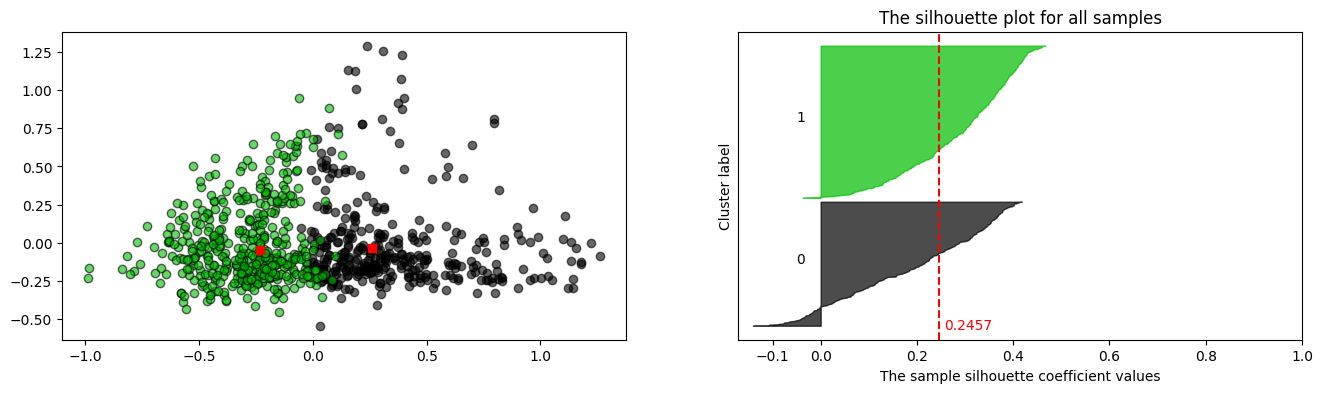

In [23]:
scatter_clusters(two_medoids, PCA_comp)

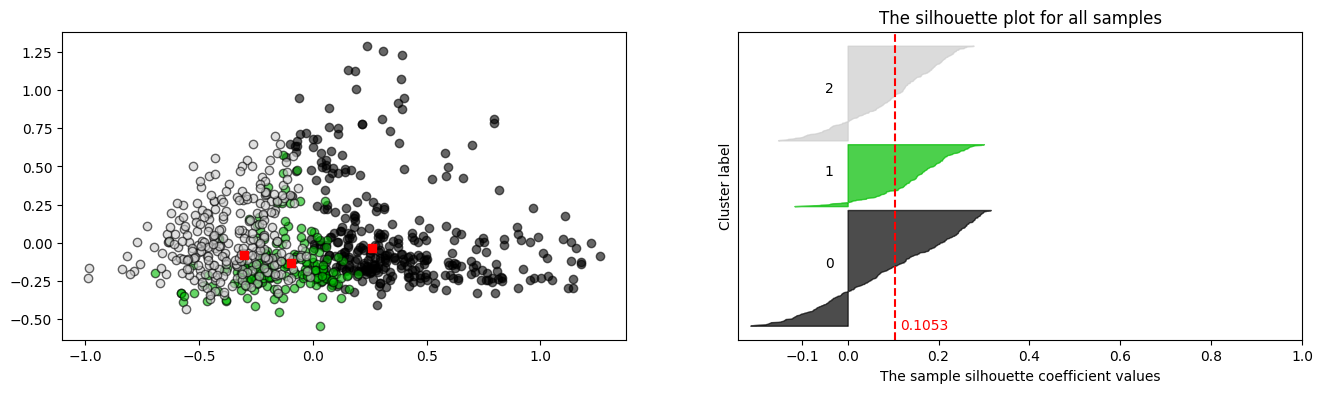

In [24]:
scatter_clusters(three_medoids, PCA_comp)

### 5. Aplicando as labels dos clusters na base original e visualizando a distribuição dos dados para cada grupo.

In [25]:
kmeans = Pipeline(steps=[("scaler", MinMaxScaler()),
                       ("clusterer", two)])

In [26]:
labels_pred = kmeans.fit_predict(X_)

In [27]:
cluster_0 = X_[labels_pred == 0]
cluster_0.insert(0, 'Cluster', 0)
cluster_1 = X_[labels_pred == 1]
cluster_1.insert(0, 'Cluster', 1)

In [28]:
cluster_1.sample(5)

Cluster   Apps  Accept  Enroll  Top10perc  Top25perc  F.Undergrad  \
517        1   2115    1540     494         28         72         2993   
59         1  20192   13007    3810         45         80        14971   
501        1   1910    1380     463         16         64         1715   
707        1   2075    1727     520         49         81         2501   
225        1   3596    2466     575         42         78         1944   

     P.Undergrad  Outstate  Room.Board  Books  Personal  PhD  Terminal  \
517          347     12825        4375    500      1500   85        85   
59          3113     18420        6810    475      1025   80        81   
501          106     13030        5860    500       750   79        88   
707          198     11800        3260    500       800   87        89   
225           46     19964        4328    500       500   94        95   

     S.F.Ratio  perc.alumni  Expend  Grad.Rate  
517       12.2           16   10175         89  
59        11.9           16   16836         72  
501       14.5           34   10190         84  
707       14.2           23    9681         95  
225       12.1           32   14720         83

In [29]:
data = pd.concat([cluster_0, cluster_1], axis=0)
data.Cluster.value_counts()

0    485
1    292
Name: Cluster, dtype: int64

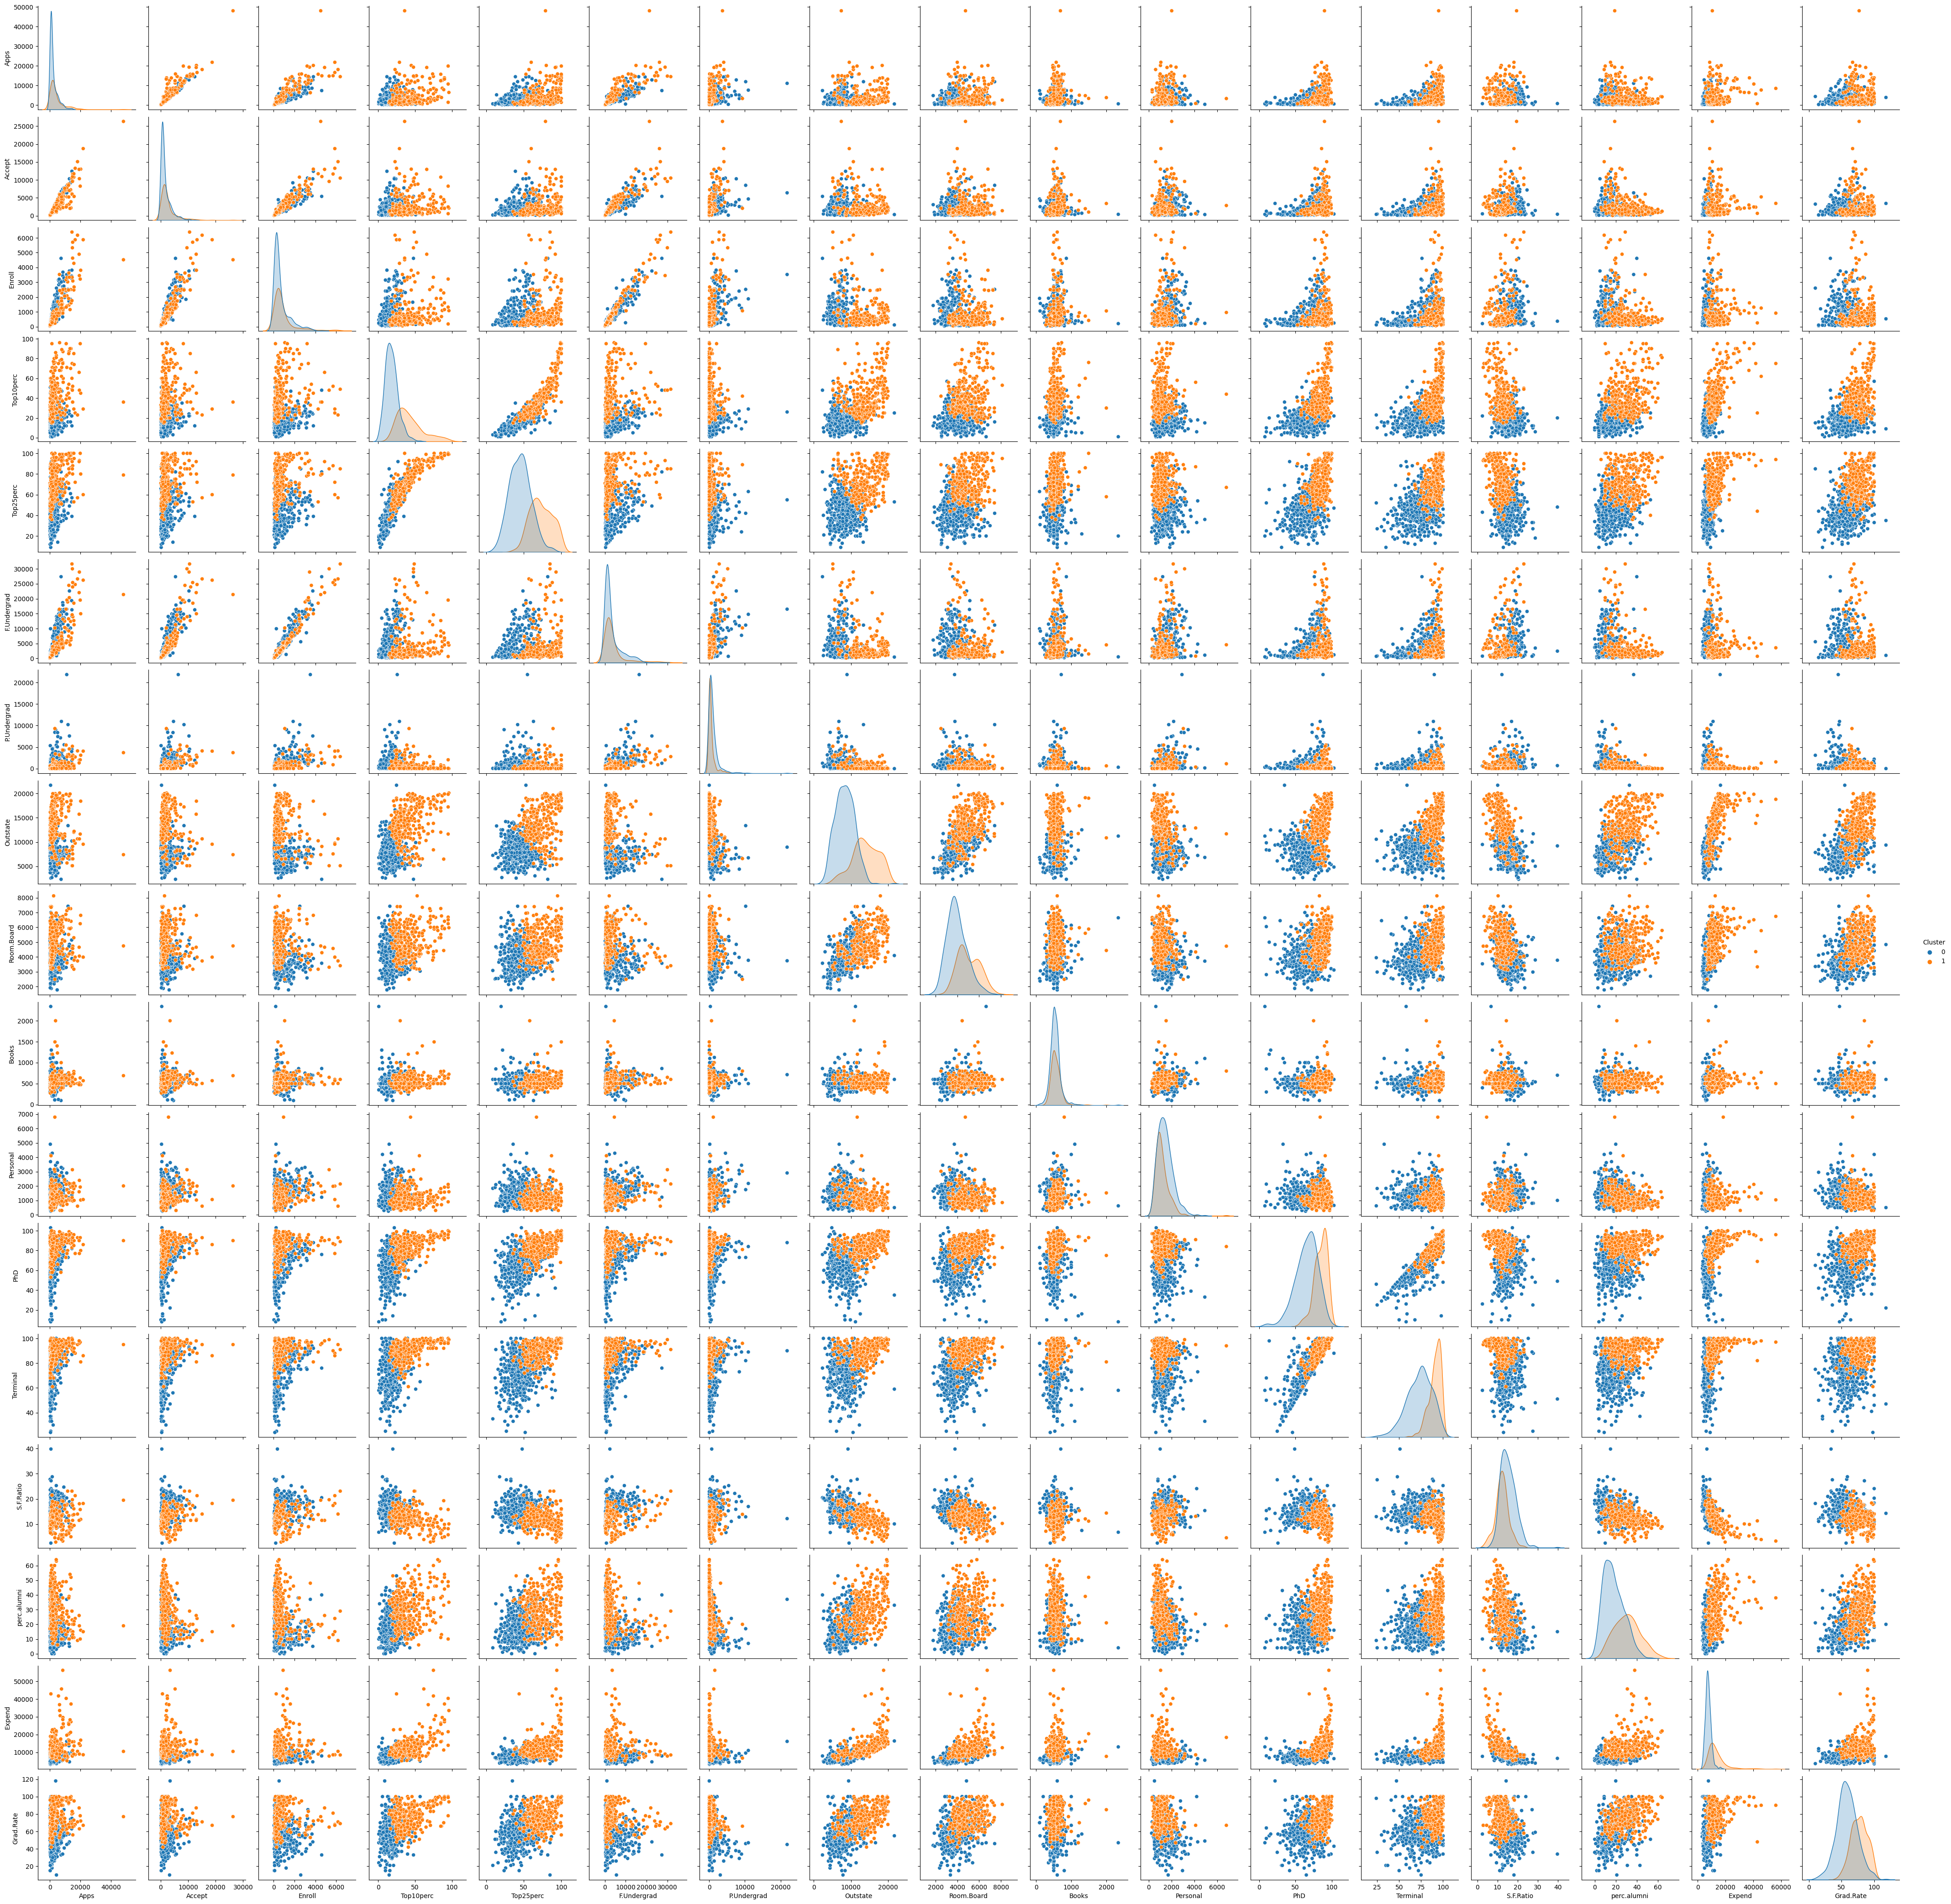

In [30]:
sns.pairplot(data, hue='Cluster')

Estimated personal spending mean for cluster 0:  1438.5896907216495
Estimated personal spending mean for cluster 1:  1177.9554794520548


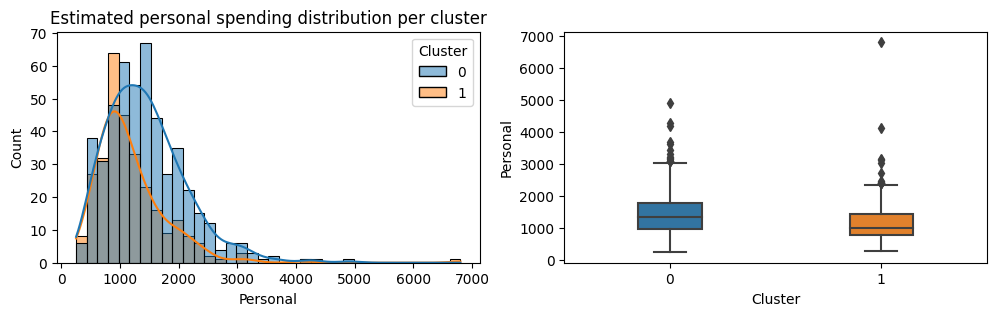

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))


sns.histplot(data=data, x='Personal', hue='Cluster', kde=True, ax=ax1)
sns.boxplot(data=data, y='Personal', x='Cluster', width=.3, ax=ax2)
print("Estimated personal spending mean for cluster 0: ", cluster_0.Personal.mean())
print("Estimated personal spending mean for cluster 1: ", cluster_1.Personal.mean())
ax1.set_title("Estimated personal spending distribution per cluster")
plt.show()

Instructional expenditure per student mean for cluster 0:  7457.313402061855
Instructional expenditure per student mean for cluster 1:  13319.027397260274


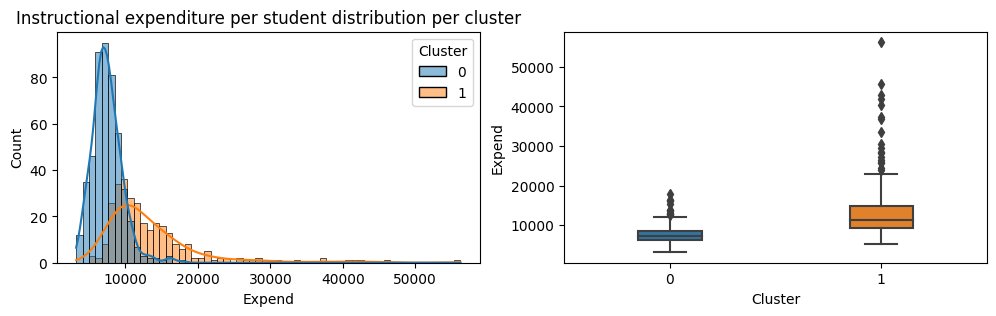

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

sns.histplot(data=data, x='Expend', hue='Cluster', kde=True, ax=ax1)
sns.boxplot(data=data, y='Expend', x='Cluster', width=.3, ax=ax2)
print("Instructional expenditure per student mean for cluster 0: ", cluster_0.Expend.mean())
print("Instructional expenditure per student mean for cluster 1: ", cluster_1.Expend.mean())
ax1.set_title("Instructional expenditure per student distribution per cluster")
plt.show()

Out-of-state tuition mean for cluster 0:  8345.950515463917
Out-of-state tuition mean for cluster 1:  13919.910958904109


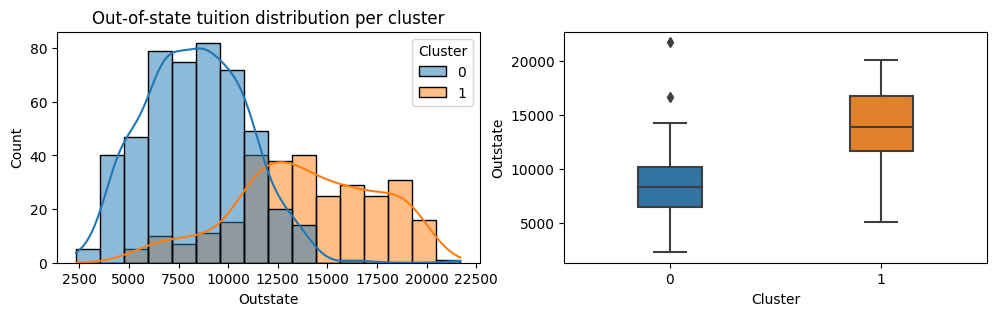

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

sns.histplot(data=data, x='Outstate', hue='Cluster', kde=True, ax=ax1)
sns.boxplot(data=data, y='Outstate', x='Cluster', width=.3, ax=ax2)
print("Out-of-state tuition mean for cluster 0: ", cluster_0.Outstate.mean())
print("Out-of-state tuition mean for cluster 1: ", cluster_1.Outstate.mean())
ax1.set_title("Out-of-state tuition distribution per cluster")
plt.show()

Graduation rate mean for cluster 0:  58.437113402061854
Graduation rate mean for cluster 1:  77.13356164383562


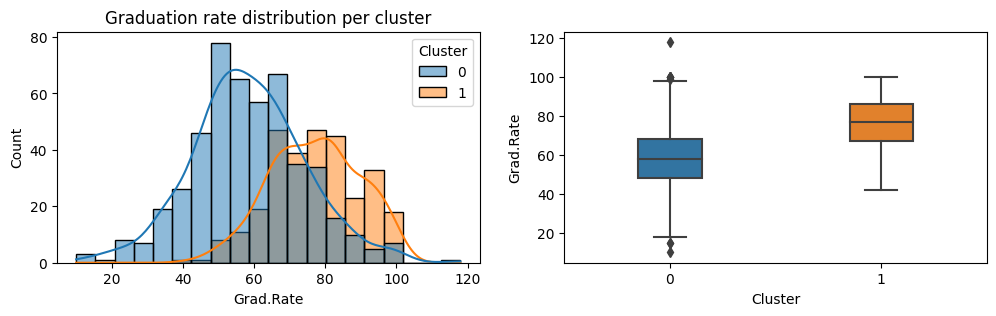

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

sns.histplot(data=data, x='Grad.Rate', hue='Cluster', kde=True, ax=ax1)
sns.boxplot(data=data, y='Grad.Rate', x='Cluster', width=.3, ax=ax2)
print("Graduation rate mean for cluster 0: ", cluster_0['Grad.Rate'].mean())
print("Graduation rate mean for cluster 1: ", cluster_1['Grad.Rate'].mean())
ax1.set_title("Graduation rate distribution per cluster")
plt.show()

Pct. of faculty with terminal degree mean for cluster 0:  73.12371134020619
Pct. of faculty with terminal degree mean for cluster 1:  90.63013698630137


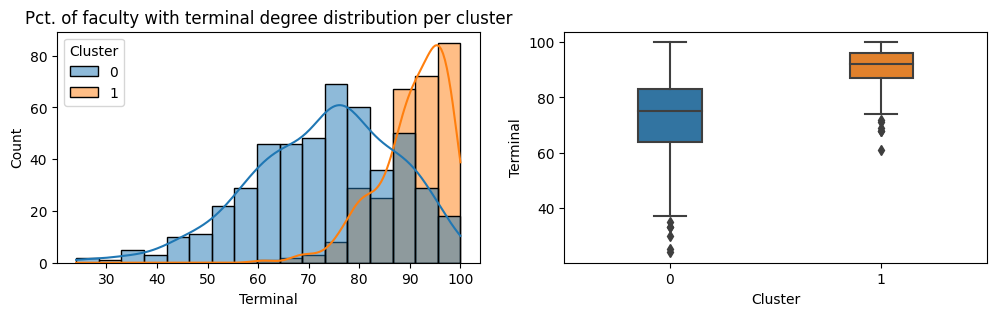

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

sns.histplot(data=data, x='Terminal', hue='Cluster', kde=True, ax=ax1)
sns.boxplot(data=data, y='Terminal', x='Cluster', width=.3, ax=ax2)
print("Pct. of faculty with terminal degree mean for cluster 0: ", cluster_0.Terminal.mean())
print("Pct. of faculty with terminal degree mean for cluster 1: ", cluster_1.Terminal.mean())
ax1.set_title("Pct. of faculty with terminal degree distribution per cluster")
plt.show()

### 6. Conclusão

Através dos gráficos apresentados previamente, podemos inferir que o cluster definido como "0" está relacionado às universidades públicas enquanto o cluster "1", às privadas.
Ademais, quando comparamos as labels dadas pelos clusters do K-means com as labels da coluna "Private" da base original, não obtemos uma acurácia boa. Assim, por mais que o algoritmo possa agrupar os dados de tal maneira que percebamos características distintas e expressivas em cada grupo, não é uma boa alternativa para classificar essa base de dados de maneira supervisionada.

In [36]:
confusion_matrix(labels, labels_pred)

array([[170,  42],
       [315, 250]], dtype=int64)

In [37]:
accuracy_score(labels, labels_pred)

0.5405405405405406